## Importing Libraries

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# Camber line For NACA 4 digit airfoil using maximum camber (m) in percentage of the chord(airfoil length),
# and position of the maximum camber (p) in tenths of chord
# Assumption 1. Airfoil is normalized, with leading edge at x = 0 and trailing edge at x = 1
# Assumption 2. So airfoil length is 1


## Quantities to be defined by User

In [94]:
## Case 1 NACA 2412 airfoil so m = 0.02 p = 0.40
## m = (Max camber in per/100)*c where c is chord length
# m

## p = (Max camber pos in per/100)*c where c is chord length
# p

## Angle of attack ( deg )
# aoa

## free stream speed ( m/s )
# u_infi

## generating n points along the chord line (x)
# n

## generating nn points for plotting vector field
# nn

## Creating Desired Airfoil's camber line coordinates

In [95]:
def airfoil_plot(m, p, n):

    # dividing X into n points
    X = np.linspace(0,1,n, dtype = float).round(4)
    # making n Y points
    Y = np.zeros_like(X)

    # plotting X, Y coordinates of desired airfoil's camber line using NACA formula
    for i, x in enumerate(X):
        if x<p:
            Y[i] = (m/(p**2)) * (2*p*x - x**2)
        if x>=p:
            Y[i] = (m/((1-p)**2)) * ((1-2*p) + 2*p*x - x**2)

    Xaxis = [0]*len(X)

    # Plotting the airfoil camber line
    plt.figure(figsize=(20,8))
    plt.xlim(-0,1)
    plt.ylim(-0.2,0.2)
    plt.plot(X,Y, )
    plt.plot(X,Xaxis)
    plt.show()

    # creating list of camber coordinates
    clc = []
    for i in range(len(X)):
        clc.append([X[i], Y[i]])

    return X, Y, clc

# Slope Calculation

In [96]:
def camber_slope(x, clc):

    left_point = None
    right_point = None

    for i in range(len(clc) - 1):
        if clc[i][0] <= x <= clc[i + 1][0]:
            left_point = clc[i]
            right_point = clc[i + 1]
            break

    if left_point is None or right_point is None:
        raise ValueError("Unable to find points on the camber line for the given x-coordinate.")

    # Calculating slope using the two closest points
    dx = right_point[0] - left_point[0]
    dy = right_point[1] - left_point[1]

    slope = dy / dx


    return slope
# This function gives the slope of the camber line at a point
# To plot the slope of the camber line along x (dy/dx vs x) run the slope plotting code


# Slope Plotting Function (dy/dx vs x)


In [97]:
# Now plotting the slope of the camber line along x (dy/dx vs x)
# clc is the list of camber coordinates calculated using Function aifoil_plot
def slope_plot (clc):
    n = len(clc)
    s = np.zeros(n)
    X = np.linspace(0,1,n, dtype = float).round(4)
    for i,x in enumerate(X):
        s[i] = camber_slope(x,clc)

    plt.plot(X,s)
    plt.xlabel('x')
    plt.ylabel('dy/dx')
    # plt.plot(X,Xaxis)
    plt.show()

## Coefficient of lift

In [98]:
def coefficient_of_lift(n, aoa, X, clc):

    ## coverting deg to radians
    alpha = aoa*np.pi/180

    ## Finding theta transformation of X coordi
    theta = np.zeros(n)
    i = 0
    for i in range (n):
        theta[i] = np.arccos(1-(2*X[i]))

    ## Finding d_theta
    d_theta = np.zeros(n)
    i = 0
    for i in range (n-1):
        d_theta[i] = theta[i+1]-theta[i]

    d_theta[n-1] = d_theta[n-2]+0.15 # normalizing end boundary points

    ## finding d_s
    d_s = np.zeros(n)
    i = 0
    for i in range (n):
        d_s[i] = np.sqrt(1+(camber_slope(X[i],clc))*(camber_slope(X[i],clc)))/n

    ## Finding A(n)'s
    A = np.zeros(n)
    i = 0
    while i<n:
        s = 0
        j = 0
        for j in range(n):
            s = s + camber_slope(X[j],clc)*np.cos((i)*theta[j])*d_theta[j]
        A[i] = s*2/np.pi
        i = i+1
    A[0] = alpha - 0.5*A[0]  # normalizing A[0]

    ## coefficient of lift
    cl = np.pi*(2*A[0]+A[1])
    print('Coefficient of lift:', cl)

    ## coefficient of moment about leading edge
    Cm = np.pi*(A[0]+A[1]-A[2]*0.5)*2
    print("Coefficient of Moment about leading edge:", Cm)

    return A, theta, d_s

## Vector field plot

In [99]:
def vector_field(n, nn, u_infi, A, theta, X, Y, d_s ):

    ## vorticity at each nth point
    gamma = np.zeros(n)
    i = 0
    while i<n:
        s = 0
        j = 0
        for j in range(n):
            s = s + A[j]*np.sin(j*theta[i])

        gamma[i] = 2*u_infi*( A[0]*((1+np.cos(theta[i]))/(np.sin(theta[i])+0.000001)) + s)
        i = i+1

    gamma[0]=0  # going for 0, instead of infi
    gamma[n-1]=0 # value was anways close to 0, so made it o for kutta condition

    ## defining a funtion to get the net induced velocity on a point (x,y)
    def v_ind(Xx, Yy):
        # in biot savarts law, assuming abs(dl)=1
        # contains the net velocity_x induced on point (x,y)
        uu = np.zeros((nn, nn))
        vv = np.zeros((nn, nn))

        for j in range(nn):
            for i in range(nn):

                x = Xx[i,j]
                y = Yy[i,j]

                # x component velocity
                v_x = 0
                v_y = 0
                for t in range(n):
                    s = np.sqrt((y-Y[t])*(y-Y[t]) + (x-X[t])*(x-X[t]))
                    dv_y = -gamma[t]*(x-X[t])/(2*np.pi*s*s)*d_s[t]      #infi line of vortex
                    v_y = v_y + dv_y                                        #assuming this magnitude of
                                                                            # stays constant through length ds
                    dv_x = gamma[t]*(y-Y[t])/(2*np.pi*s*s)*d_s[t]       #infi line of vortex
                    v_x = v_x + dv_x
                vv[i, j] = v_y
                uu[i, j] = v_x

        return uu, vv

    ## data collection for plotting
    # Creating data set

    Aa = np.linspace(-1.5, 2.5, nn)
    Bb = np.linspace(-1.5, 1.5, nn)

    Yy, Xx = np.meshgrid(Bb, Aa)

    U, V= v_ind(Xx, Yy)
    U = U+u_infi # freestream component


    # removing points close to the airfoil
    for j in range(nn):
        for i in range(nn):
            for t in range(n):
                if np.sqrt((Yy[i, j]-Y[t])*(Yy[i, j]-Y[t]) + (Xx[i, j]-X[t])*(Xx[i, j]-X[t]))<0.005:
                    U[i, j] = 0
                    V[i, j] = 0

    # Create the plot

    plt.figure(figsize=(12,10))

    # Set the x-limits and y-limits of the plot
    plt.xlim([-1.5, 2.5])
    plt.ylim([-1.5, 1.5])

    plt.quiver(Xx, Yy, U, V, scale=2000, width=0.001) #, angles='xy', scale_units='xy', scale=1, color='r')

    # camber line
    plt.plot(X,Y, color ='blue')

    # Show the plot along with the grid
    plt.grid()
    plt.show()

    return gamma

## Circulation Functions

Bound circulation by integrating circulation distribution along camber line

In [100]:

def net_bound_circulation(n, d_s, gamma):

    # calculating circulation due to airfoil through line integral
    circ = 0
    for i in range (n):
        circ += gamma[i]*d_s[i]

    print ("Total bound circulation is:", circ)

Circulation around the entire airfoil using velocity line-integral approach



In [101]:
# Preliminary things
# Function to calculate vel at point (x,y)
def vel(xx, yy,u_infi, clc,aoa):
    ## coverting deg to radians
    alpha = aoa*np.pi/180

    ## Finding theta transformation of X coordi
    n = len(clc)
    X = [point[0] for point in clc]
    Y = [point[1] for point in clc]

    theta = np.zeros(n)
    i = 0
    for i in range (n):
        theta[i] = np.arccos(1-(2*X[i]))

    ## Finding d_theta
    d_theta = np.zeros(n)
    i = 0
    for i in range (n-1):
        d_theta[i] = theta[i+1]-theta[i]

    d_theta[n-1] = d_theta[n-2]+0.15 # normalizing end boundary points

    ## finding d_s
    d_s = np.zeros(n)
    i = 0
    for i in range (n):
        d_s[i] = np.sqrt(1+(camber_slope(X[i],clc))*(camber_slope(X[i],clc)))/n

    ## Finding A(n)'s
    A = np.zeros(n)
    i = 0
    while i<n:
        s = 0
        j = 0
        for j in range(n):
            s = s + camber_slope(X[j],clc)*np.cos((i)*theta[j])*d_theta[j]
        A[i] = s*2/np.pi
        i = i+1


    A[0] = alpha - 0.5*A[0]  # normalizing A[0]

    gamma = np.zeros(n)
    i = 0
    while i<n:
        s = 0
        j = 0
        for j in range(n):
            s = s + A[j]*np.sin(j*theta[i])

        gamma[i] = 2*u_infi*( A[0]*((1+np.cos(theta[i]))/(np.sin(theta[i])+0.000001)) + s)
        i = i+1

    gamma[0]=0  # going for 0, instead of infi
    gamma[n-1]=0 # value was anways close to 0, so made it o for kutta condition
 ## defining a funtion to get the net induced velocity on a point (x,y)
    uu = np.zeros(360)
    vv = np.zeros(360)
    for i in range (360):
      # in biot savarts law, assuming abs(dl)=1
      x = xx[i]
      y = yy[i]
      v_x = 0
      v_y = 0
      for t in range(n):
          s = np.sqrt((y-Y[t])*(y-Y[t]) + (x-X[t])*(x-X[t]))
          dv_y = -gamma[t]*(x-X[t])/(2*np.pi*s*s)*d_s[t]      #infi line of vortex
          v_y = v_y + dv_y                                        #assuming this magnitude of
                                                                  # stays constant through length ds
          dv_x = gamma[t]*(y-Y[t])/(2*np.pi*s*s)*d_s[t]       #infi line of vortex
          v_x = v_x + dv_x

      uu[i] = v_x + u_infi
      vv[i] = v_y
    return uu, vv


In [102]:
# Line-integral approch by integrating along an ellipse a = 3, b = 2 centre at (0.5,0)

def net_circulation_vel_approach(u_infi, clc, aoa):

  # dividing ellipse in 360 part to create a infinitely small element over it
  d_t = np.linspace(0, 2*np.pi, 360)

  X_ = 3*np.cos(d_t)
  Y_ = 2*np.sin(d_t)
  U, V = vel(X_, Y_,u_infi, clc,aoa)
  dx = np.diff(X_)
  dy = np.diff(Y_)
  circ = 0
  for i in range (359):

    circ  -= dx[i]*U[i]+ dy[i]*V[i]

  print ("Total circulation using velocity approach is:", circ)



## Overall Code

In [106]:
def airfoil_properties(m, p, aoa, u_infi, n, nn):
    X, Y, clc = airfoil_plot(m, p, n)
    slope_plot(clc)
    A, theta, d_s = coefficient_of_lift(n, aoa, X, clc)

    gamma = vector_field(n, nn, u_infi, A, theta, X, Y, d_s)

    net_bound_circulation(n, d_s, gamma)

    net_circulation_vel_approach(u_infi, clc, aoa)


## Output

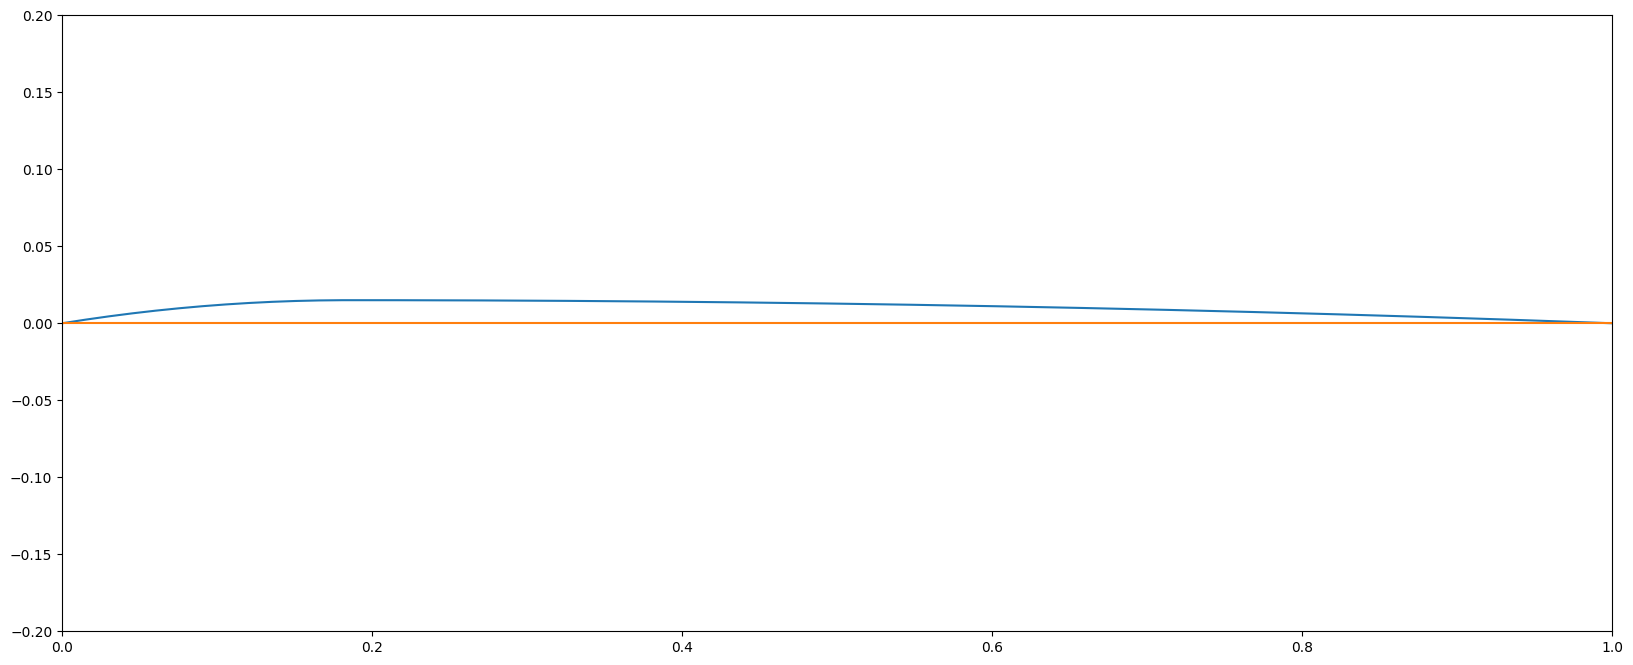

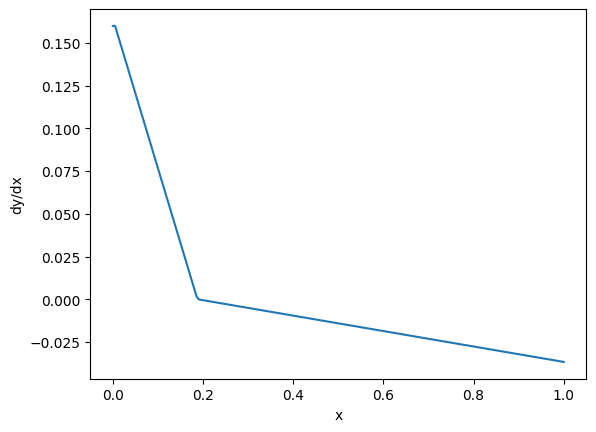

Coefficient of lift: 1.5034309032075248
Coefficient of Moment about leading edge: 1.6518436831996424


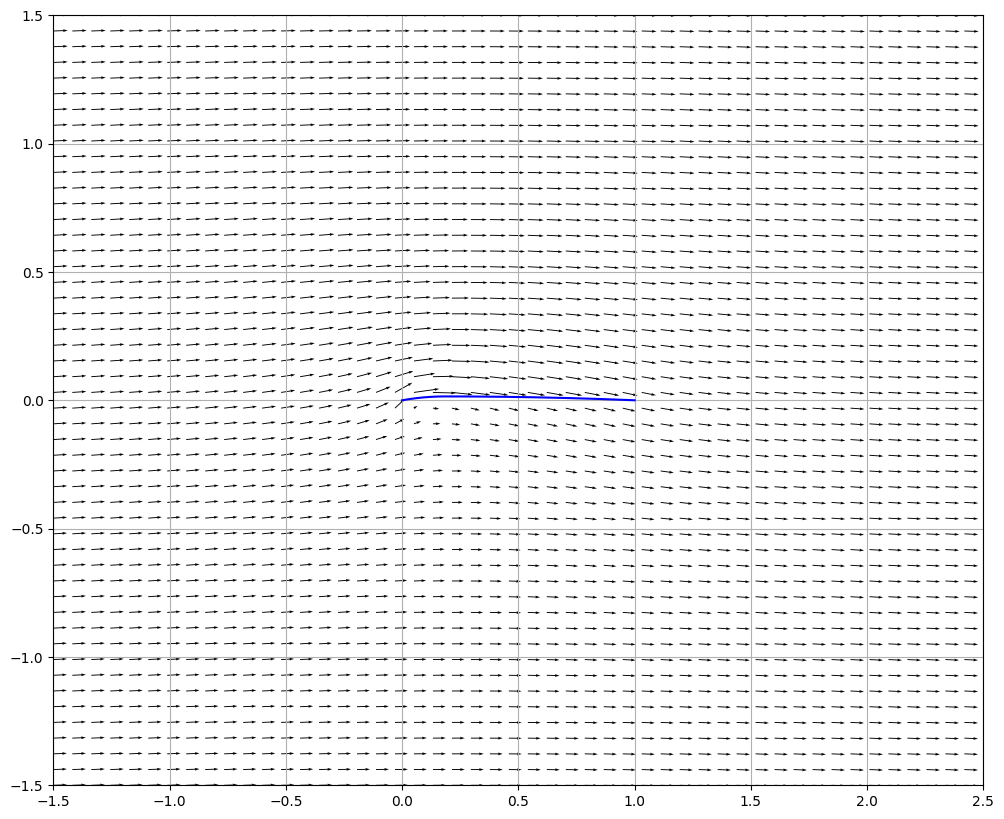

Total bound circulation is: 21.227911615727553
Total circulation using velocity approach is: 21.22682788794208


In [107]:
airfoil_properties(0.015, 0.185, 12, 30, 200, 50)